In [1]:

import os
import pandas as pd
import numpy as np
import csv
import requests
from bs4 import BeautifulSoup 
import re
import undetected_chromedriver as uc
import time
import fractions
import traceback
from ctypes import pythonapi
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns

%matplotlib inline

# form pythonapi.display import display

from plotnine import *
from plotnine import ggplot
from collections import Counter
from sklearn.decomposition import PCA
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from fractions import Fraction


In [2]:

url = "https://www.udemy.com/courses/development/data-science/?p=1"
url_format = "https://www.udemy.com/courses/development/data-science/?p={0}"
url_base = "https://www.udemy.com"

columns_list=['course name',
              'Link to course',
              'Number of students who purchased the course',
              'The number of students who rated the course',
              'The number of factors that took part in the creation of the course',
              'Last updated date',
              'the language of the course',
              'The number of languages into which the course is translated',
              'The number of languages for which the course has subtitles',
              'price',
              'Is the course on sale?',
              'The number of episodes',
              'Number of lectures in the course',
              'Duration of each lecture',
              'The name of the first lecturer',
              'Number of followers of the first lecturer',
              'The course number of the first lecturer',
              'Average rating of all courses of the first lecturer',
              'The name of the second lecturer',
              'Number of followers of the second lecturer',
              'The course number of the second lecturer',
              'Average rating of all courses of the second lecturer',
              'Does the course contain exercises?',
              'Does the course contain exams?',
              'Does the course contain a final exam?',
              'Course rating']
              #   'Difficulty level classification of the course',

In [3]:
# bs4 is not supporting dinamic data loading, so I had to use selenium web driver 
# to get the linked javascript to the html's.
#browser.get(url)
# driver = webdriver.Chrome(executable_path = "c:\selenium browser drivers\chromedriver.exe")
browser = uc.Chrome()

: 

In [3]:
#the function returns the number of pages in the courses section. 
def pages_amount():
    browser.get(url)
    time.sleep(2)
    html=browser.page_source
    soup=BeautifulSoup(html,"html.parser")
    info=soup.find("span", {"class": "ud-heading-sm pagination--page--13HGb"})
    pages=info.text
    return pages

In [4]:
def insert_link_to_list(html_udemy_page):
    browser.get(html_udemy_page)
    time.sleep(4)
    html_udemy_page=browser.page_source
    soup=BeautifulSoup(html_udemy_page,"html.parser")
    #print(soup)
    link = list()

    mtag = soup.find("div",attrs={"class":"course-list--container--FuG0T"})#--3zXPS
    #print(mtag)
    for card in mtag.find_all("a"):
         if card.findParent('h3',attrs={"data-purpose":"course-title-url"}):
            link.append(card['href'])
            print(card['href'])

    return link

In [5]:
def get_url_for_each_page(pages_count):
    all_courses_links=[]
    for i in range(1,pages_count+1):
        curr_url=url_format.format(i)
        all_courses_links.extend(insert_link_to_list(curr_url)) #appending all lists together from each page
    return all_courses_links

In [6]:
def create_df_to_links_course():
     num = pages_amount()
     print(num)
     links = list()
     links=get_url_for_each_page(int(num))
     df = pd.DataFrame({"links":links})
     print(df) #delete 
     return df

In [7]:
def get_details_from_single_item(item_link):
    browser.get(item_link)
    time.sleep(2)
    html=browser.page_source
    soup=BeautifulSoup(html)
    
    
    #course name
    name = soup.find("h1",{"class": "ud-heading-xl clp-lead__title clp-lead__title--small"})
    name_value = name.string
    
    #Number of students who purchased the course
    Number_purchased = soup.find("div",{"class": "enrollment"})
    Number_purchased_value = Number_purchased.string.split()[0] #clear text

    #The number of students who rated the course
    try:
        Number_rated = soup.find("a",{"class": "styles--rating-wrapper--ajCRv"})
        Number_rated = Number_rated.find_all('span')[-1]
        Number_rated_value = Number_rated.string.split()[0][1:] #clear text
    except Exception as e:
        Number_rated = soup.find("div",{"class": "styles--rating-wrapper--ajCRv"})
        Number_rated = Number_rated.find_all('span')[-1]
        Number_rated_value = Number_rated.string.split()[0][1:] #clear text
    #print(Number_rated_value)
    
    #The number of factors that took part in the creation of the course
    number_of_factors_creation =       soup.find("span",{"class": "instructor-links--names--3U_NU"})
    number_of_factors_creation =       number_of_factors_creation.find_all('a')
    number_of_factors_creation_value = len(number_of_factors_creation)
    

    #Last updated date
    try:
        last_update_date =       soup.find("div",{"class": "last-update-date"})
        last_update_date =       last_update_date.find('span')
        last_update_date_value = last_update_date.string.split()[2] #clear text
    except Exception as e:
        last_update_date_value = "null"

    #the language of the course
    try:
        language =       soup.find("div",{"class": "clp-lead__element-item clp-lead__locale"})
        language_value = language.text
    except Exception as e:
        language = "null"

    #The number of languages into which the course is translated
    language_translated =       soup.find("div",{"class": "clp-lead__element-item clp-lead__locale"})
    language_translated_value = len(language_translated.text.split())

    #The number of languages for which the course has subtitles
    try:
        language_subtitles =       soup.find("div",{"class": "ud-text-sm caption--captions--joQAG"})
        num1 =       language_subtitles.find_all('span')
        if(len(num1)> 1):
            language_subtitles_value = int(len(num1[0].text.split())/2) + int(num1[-1].text.split()[0])
          #  print("text1")
        else:
            language_subtitles_value = 1
    except Exception as e:
        language_subtitles_value = 0

    #Is the course on sale?
    try:
        is_sale   = soup.find_all("div",{"class":"price-text--price-part--2npPm price-text--original-price--1sDdx ud-clp-list-price ud-text-sm"})[-1]
        is_sale_value = 1
    except Exception as e:
        is_sale_value = 0
   
    #price 
    #price
    if is_sale_value == 1:
        price  =  soup.find_all("div",{"data-purpose": "course-old-price-text"})[1]
        try:
            price_value = price.find_all('span')[-1].string[1:]
        except Exception as e:
            price_value = "null"
    else:# sale_value == 0 -> no sale
        try:
            price = soup.find_all('div',{"class":"buy-box--buy-box-item--2RETv"})[1]
            price = price.find_all('span')[-1].string
            if price == "Free":
                price_value = 0
            else:
                price_value =price.string[1:]
        except Exception as e:
            price_value = "null"


    #The number of episodes
    try:
        episodes = soup.find("div",{"data-purpose":"course-curriculum"})
        if episodes is not None:
            try:
                episodes = episodes.find('span',{"class":"curriculum--content-length--5Nict"})
                num_of_episodes = episodes.text.split()[0]
            except Exception as e:
                num_of_episodes = "null"
                traceback.print_exc()
        else:
            try:
                episodes = soup.find("span",{"class":"curriculum--content-length--5Nict"})
                num_of_episodes = episodes.text.split()[0]
            except Exception as e:
                traceback.print_exc()
                num_of_episodes = "null"
    except Exception as e:
        num_of_episodes = "nulll"

    # #Number of lectures in the course
    try:
        num_of_lectures = episodes.text.split()[3]
    except Exception as e:
        num_of_lectures = "null"

    # #time of lectures in the course
    try:
        time_of_lectures = episodes.text.split()[6] +' '+ episodes.text.split()[7] #clear text
    except Exception as e:
        time_of_lectures = "null"

    #The info of the first lecturer
   # print("test 5")
    all_lucturers = soup.find("div",{"class": "component-margin styles--instructors--1dmIT"})
    all_lucturers = all_lucturers.find_all("div",{"class": "instructor--instructor--2sjZy"})
    
    first_lucturer = all_lucturers[0]
  #  print("test 6 first lecturer")
    first_lecturer_name = first_lucturer.find("a").text
    first_lucturer = first_lucturer.find_all("li")
    first_lecturer_student = first_lucturer[2].text.split()[0]
    first_lecturer_courses = first_lucturer[3].text.split()[0]
    first_lecturer_rating  = first_lucturer[0].text.split()[0]

    #The info of the secound lecturer
    if(number_of_factors_creation_value > 1):
        secound_lucturer = all_lucturers[1]
       # print("test 7 second lecturer")
        secound_lecturer_name = secound_lucturer.find("a").text
        secound_lucturer = secound_lucturer.find_all("li")
        secound_lecturer_student = secound_lucturer[2].text.split()[0]
        secound_lecturer_courses = secound_lucturer[3].text.split()[0]
        secound_lecturer_rating  = secound_lucturer[0].text.split()[0]
    else:
        secound_lecturer_name = 'null'
        secound_lecturer_student = 'null'
        secound_lecturer_courses = 'null'
        secound_lecturer_rating = 'null'

    #Does the course contain exercises?
   # print("test 8 description")
    try:
        describe_course = soup.find("div",{"class": "incentives--incentives-container--1QKGj"})
        if (describe_course.find("span",{"data-purpose":"num-coding-exercises"})) is not None:
            exercises = 1
        else:
            exercises = 0
    except Exception as e:
        exercises = 0    
    #Does the course contain quiz?
 #   print(" test 9 quiz ")
    try:
        describe_course1 = soup.find("div",{"data-purpose":"course-curriculum"})
        if (describe_course1.find("use",{"xlink:href":"#icon-quiz"})) is not None:
            quiz = 1
        else:
            quiz = 0
    except Exception as e:
        quiz=0

    #Does the course contain a final exam?
   # print("test 10 practices")
    describe_course2 = soup.find("span",{"data-purpose":"num-practice-tests"})
    if (describe_course2) is not None:
        final_test = 1
    else:
        final_test = 0
    
    #Course rating
    try:
        rating = soup.find("span",{"class":"ud-heading-sm star-rating--rating-number--3l80q"}).text
    except Exception as e:
      #  print("Rating Error")
        rating = 0

    line = {'course name':name_value,
            'Link to course':item_link,
            'Number of students who purchased the course':Number_purchased_value,
            'The number of students who rated the course':Number_rated_value,
            'The number of factors that took part in the creation of the course':number_of_factors_creation_value,
            'Last updated date':last_update_date_value,
            'the language of the course':language_value,
            'The number of languages into which the course is translated':language_translated_value,
            'The number of languages for which the course has subtitles':language_subtitles_value,
            'price':price_value,
            'Is the course on sale?':is_sale_value,
            'The number of episodes':num_of_episodes,
            'Number of lectures in the course':num_of_lectures,
            'Duration of each lecture':time_of_lectures,
            'The name of the first lecturer':first_lecturer_name,
            'Number of followers of the first lecturer':first_lecturer_student,
            'The course number of the first lecturer':first_lecturer_courses,
            'Average rating of all courses of the first lecturer':first_lecturer_rating,
            'The name of the second lecturer':secound_lecturer_name,
            'Number of followers of the second lecturer':secound_lecturer_student,
            'The course number of the second lecturer':secound_lecturer_courses,
            'Average rating of all courses of the second lecturer':secound_lecturer_rating,
            'Does the course contain exercises?':quiz,
            'Does the course contain exams?':exercises,
            'Does the course contain a final exam?':final_test,
            'Course rating':rating}
             #'Difficulty level classification of the course':,

    return line
  

In [8]:
def insert_details_to_dataframe(df_main,line):
    df_main=df_main.append( pd.Series(line), ignore_index=True)
    return( df_main)

In [9]:
def merge_dataframes(dataframe_list):
    df = dataframe_list[0]
    for i in range(1, len(dataframe_list)):
        df = pd.concat([df, dataframe_list[i]], axis=0, join='outer')
    return df

In [10]:
def create_main_df(df_main,df_links):
    num_of_rows = df_links.shape[0]
    del_list = list()
    df_delete_courses = pd.DataFrame({"name": del_list})
    for i in range(0,num_of_rows):
        url_course = url_base + df_links.iloc[i,1]
        try:
            item_dictionary=get_details_from_single_item(url_course)
            df_main=insert_details_to_dataframe(df_main,item_dictionary)
            if((i > 99) and ((i % 100) == 0)):
                df_main.to_csv("test_{0}.csv".format(i))##backup save
        except Exception as e:
            df_main.to_csv("test_{0}.csv".format(i-1))
            print(e)
            traceback.print_exc()
            print(url_course)
            del_list.append(url_course)##list of courses with errors
            df_delete_courses.to_csv("delete_list1.csv".format(i))##csv file for the problematic courses

    

    return (df_main)

In [13]:
def fix_null_values(df_main,df_links):
    num_of_rows = df_links.shape[0]
    for link in df_links:
        #url_course =df_links.iloc[i,0]
        try:
            item_dictionary=get_details_from_single_item(link)
            df_main=insert_details_to_dataframe(df_main,item_dictionary)
           
        except Exception as e:
            print(e)
            traceback.print_exc()
            print(link)
  

    return (df_main)

In [ ]:
#Future main block - generates links of courses, main data of each course
df_links_to_courses = pd.DataFrame()
#df_links_to_courses = create_df_to_links_course()
#df_links_to_courses.to_csv("links_to_courses.csv")
df_links_to_courses = pd.read_csv("links_to_courses.csv")
df_main = pd.DataFrame()
df_main = create_main_df(df_main,df_links_to_courses)
df_main.to_csv('check.csv')





In [13]:
# This cell is another part of main - serves to make order with the csv files and merge them all together
df_1 = pd.read_csv("test_1000.csv") #0-999
df_2 = pd.read_csv("test_1723.csv")#1000-1722
df_3 = pd.read_csv("test_2498.csv")#1723-2497
df_4 = pd.read_csv("check.csv")#3000-end
list_df = [df_1,df_2,df_3,df_4]
total_df = merge_dataframes(list_df)
total_df = total_df.drop_duplicates()
total_df.drop('Unnamed: 0',axis=1,inplace=True)
total_df = total_df.reset_index(drop=True)
total_df.to_csv('total_df.csv')

In [14]:
#Function that catches the null values and sorts them into a list of links in order to crawl again 
def second_crawl_for_false_null_values(df_main):
    df_copy = df_main.copy()
    df_main = df_main.dropna(subset=['The number of episodes', 'Number of lectures in the course', 'Duration of each lecture'])
    df_copy = df_copy.loc[(df_copy['The number of episodes'].isnull())| (df_copy['Number of lectures in the course'].isnull()) | (df_copy['Duration of each lecture'].isnull())] 
    links_to_courses = pd.DataFrame()
    links_to_courses = df_copy['Link to course']
    links_to_courses = links_to_courses.reset_index(drop=True)
    return links_to_courses

In [ ]:
new_list_to_course = pd.DataFrame()
new_list_to_course = second_crawl_for_false_null_values(total_df)
# final_df.to_csv('final_df.csv')
final_df = fix_null_values(total_df,new_list_to_course)
final_df = final_df.reset_index(drop=True)
final_df.to_csv('final_df.csv')

In [67]:
def convert_duration_to_float(duration_str):
    if 'h' in duration_str:
        hours, minutes = duration_str.split('h ')
        if int(hours) == 0:
            return float(minutes.replace('m',''))/60
        else:
            return float(hours) + float(minutes.replace('m',''))/60
    else:
        return float(duration_str.replace('m total', ''))/60


In [68]:
def replace_missing_values(df2):
    df = df2.copy()

    # col 7 - the_language_of_the_course - marks the course's language with a categorical value.
    value_counts = df['the language of the course'].value_counts()
    classification_dict = {value: i+1 for i, value in enumerate(value_counts.index)}
    df['the language of the course'].replace(classification_dict, inplace=True)

    # col 6 Last_updated_date - fills the null values with the most common date
    most_common = df['Last updated date'].mode().iloc[0]
    df['Last updated date'].fillna(most_common, inplace=True)

    # cols 11,12,13 - drops the rows with null values after second_crawl_for_false_null_values function result
    df.dropna(subset=['The number of episodes', 'Number of lectures in the course', 'Duration of each lecture'],inplace=True)

    #col 13 - Duration_of_lectures - converts the default value to real number
    df['Duration of each lecture'] = df['Duration of each lecture'].apply(convert_duration_to_float)

    #cols 2,3,15,16,19 - converts the following columns from string to numeric values.
    cols = ['Number of students who purchased the course',
            'The number of students who rated the course',
            'Number of followers of the first lecturer',
            'The course number of the first lecturer',
            'Number of followers of the second lecturer']
    for col in cols:
        df[col] = pd.to_numeric(df[col].replace({',':'','--':''},regex=True))


    #col 17 - Average_rating_of_all_courses_of_the_first_lecturer - 
    # converts the string values to numeric values + fills with median value the empty cells
    df['Average rating of all courses of the first lecturer'] = pd.to_numeric(df['Average rating of all courses of the first lecturer'].str.replace('--',''))
    col_numery = {'Average rating of all courses of the first lecturer':df["Average rating of all courses of the first lecturer"].median()}
    df=df.fillna(col_numery)
    
    #col 18 - The_name_of_the_second_lecturer - converts into boolean value
    df['The name of the second lecturer'] = df['The name of the second lecturer'].notnull().astype(int)

    #col 19,20,21 - fills the following columns with '0' value if cell is empty (the columns are represented by boolean value)
    col_secound = {'Number of followers of the second lecturer':0 ,
                'The course number of the second lecturer':0, 
                'Average rating of all courses of the second lecturer':0,
                'Number of followers of the first lecturer':0}
    df = df.fillna(col_secound)




    return df

In [69]:
final_df = pd.read_csv("final_df.csv")

In [70]:
try:
    clean_df = replace_missing_values(final_df)
    clean_df.drop('Unnamed: 0',axis=1,inplace=True)
    clean_df = clean_df.reset_index(drop=True)
    clean_df.to_csv('clean.csv')
except Exception as e:
    traceback.print_exc()


In [71]:
#Columns for normalizing : Number of students who purchased the course,
#                          The number of students who rated the course,
#                          price,
#                          The number of languages for which the course has subtitles,
#                          The number of episodes
#                          Number of lectures in the course
#                          Duration of each lecture
#                          Number of followers of the first lecturer
#                          The course number of the first lecturer
#                          Average rating of all courses of the first lecturer
#                          Number of followers of the second lecturer
#                          The course number of the second lecturer
#                          Average rating of all courses of the second lecturer
#                          Course rating







In [82]:
df = pd.read_csv("clean.csv")
dataset=df.copy()

<Axes: xlabel='Course rating'>

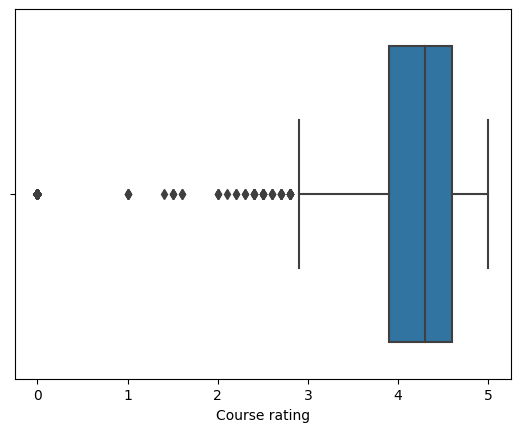

In [83]:
sns.boxplot(x=dataset["Course rating"], orient='horizontal')

<Axes: xlabel='price'>

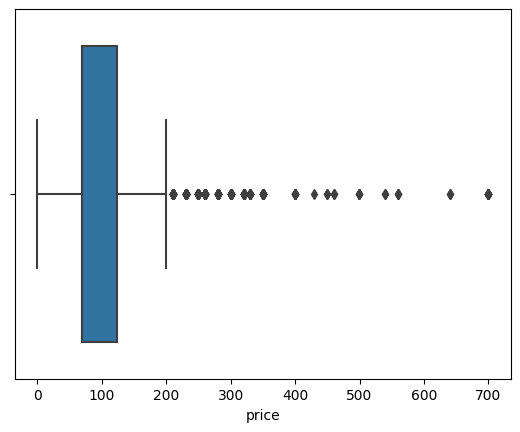

In [84]:
sns.boxplot(x=dataset["price"], orient='horizontal')

0.146240497902872

<Figure size 5000x2000 with 0 Axes>

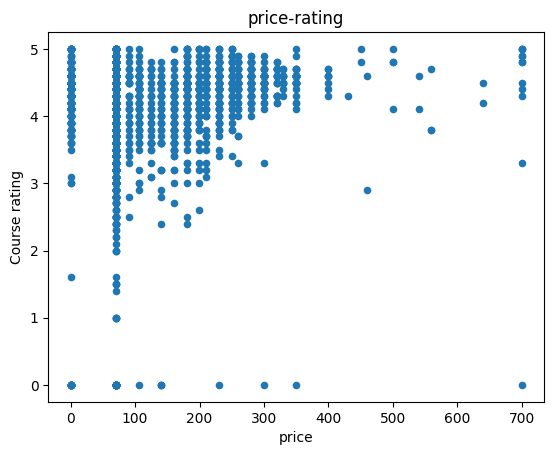

In [85]:
fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','price']].plot(title='price-rating',x='price',y='Course rating',kind='scatter')

dataset['price'].corr(dataset['Course rating'])

0.1758110031261225

<Figure size 5000x2000 with 0 Axes>

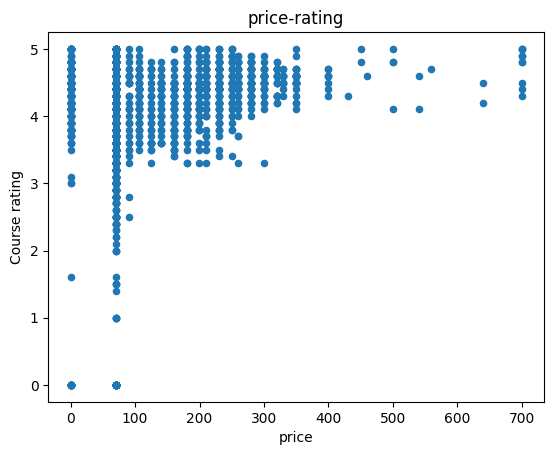

In [86]:
index_to_remove=[]
index_to_remove.append(dataset.query('(`Course rating` < 3.3 ) & (price > 100)|(`Course rating` < 4.0) & (price > 401)').index)
dataset.drop(index=index_to_remove[0].values,inplace=True)
dataset.reset_index(inplace=True,drop=True)

fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','price']].plot(title='price-rating',x='price',y='Course rating',kind='scatter')

dataset['price'].corr(dataset['Course rating'])

<Axes: xlabel='price'>

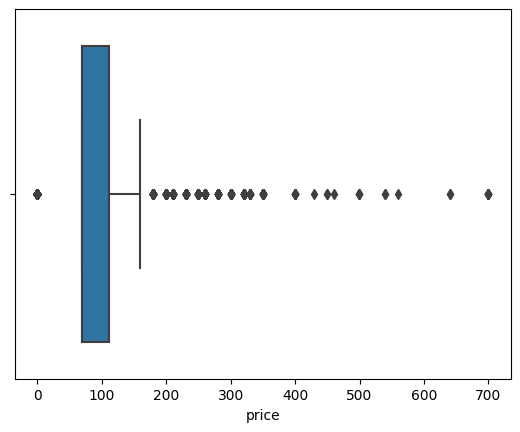

In [87]:
sns.boxplot(x=dataset["price"], orient='horizontal')


<Axes: xlabel='Course rating'>

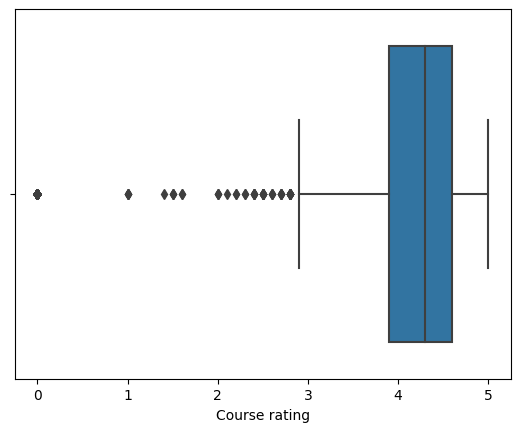

In [88]:
sns.boxplot(x=dataset["Course rating"], orient='horizontal')

  price_binned      mean
0            2  3.823049
1            3  4.233957
2            4  4.451190
3            1  4.090323
4            5  4.541975
5            6  4.656522


<Axes: xlabel='price_binned'>

<Figure size 2000x1000 with 0 Axes>

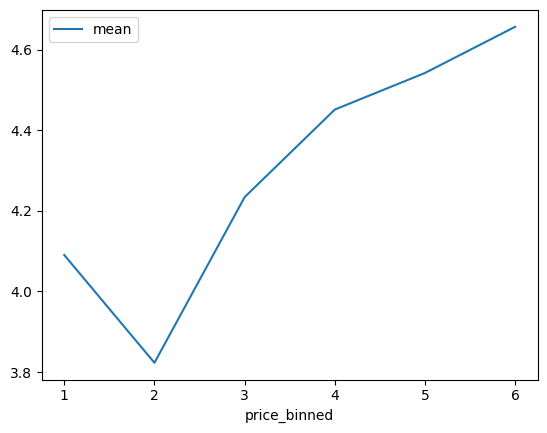

In [89]:
#Define bins and labels for further data handling
bins = [0,1,100,200,300,400,700]
labels =  [1,2,3,4,5,6]
dataset['price_binned'] = pd.cut(x = dataset['price'], bins = bins, labels = labels, include_lowest = True)
dataset.drop('price',inplace=True,axis=1)
prices=dataset['price_binned'].value_counts().keys()
##calculate the mean of course ratings
price_mean=[]
for price in prices:
    price_mean.append(dataset.loc[dataset['price_binned'] == price,['Course rating']].mean().values[0])
df_price_mean=pd.DataFrame({'price_binned':prices,'mean':price_mean})
df_price_mean.sort_values(by='mean',ascending=False)
#shows the bins of prices and the correlation between price and ratings
print(df_price_mean)
fig = plt.figure(figsize=(20,10))
df_price_mean.sort_values(by='price_binned',ascending=True).plot(x='price_binned',kind='line')

In [90]:
#calculate the correlation between the prices and the course - we can notice that the correlation is pretty weak
dataset['price_binned'].corr(dataset['Course rating'])


0.1747385948885556

<Axes: xlabel='Number of students who purchased the course'>

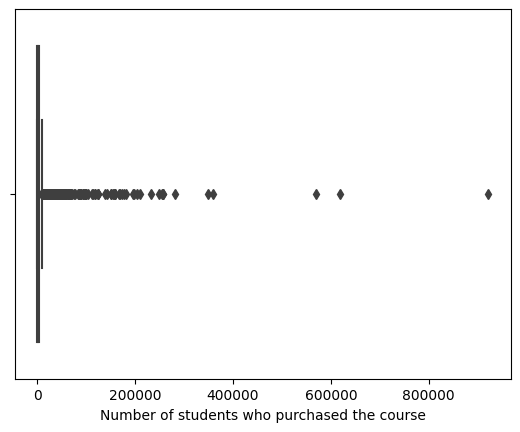

In [95]:
#Box plot representation of Number of students who purchased the course
sns.boxplot(x=dataset["Number of students who purchased the course"], orient='horizontal')

0.0740171205219062

<Figure size 5000x2000 with 0 Axes>

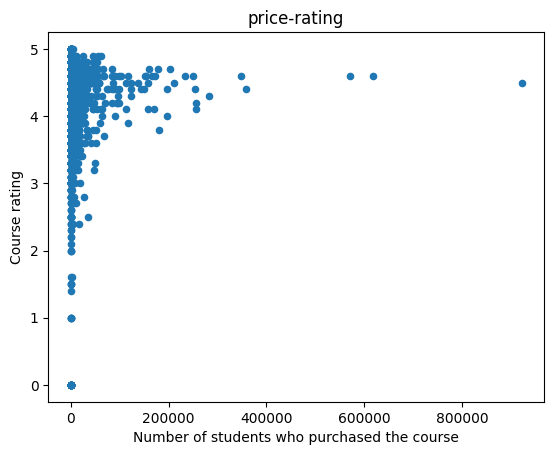

In [96]:
fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','Number of students who purchased the course']].plot(title='price-rating',x='Number of students who purchased the course',y='Course rating',kind='scatter')

dataset['Number of students who purchased the course'].corr(dataset['Course rating'])

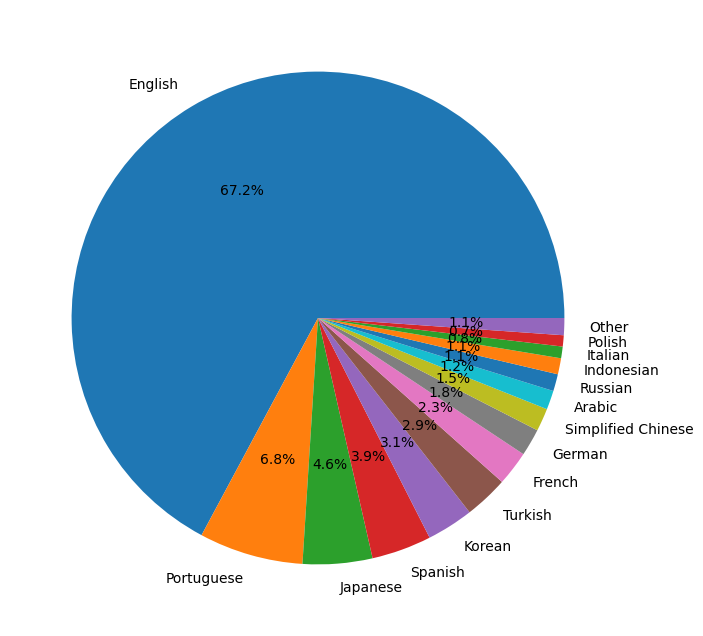

In [113]:
df = pd.read_csv("final_df.csv")
dataset=df.copy()
data_dict = dataset['the language of the course'].value_counts().to_dict()

# merge the 20 least common languages into a single category called "Other"
threshold = 20
other_count = sum(count for count in data_dict.values() if count < threshold)
data_dict = {k: v for k, v in data_dict.items() if v >= threshold}
data_dict['Other'] = other_count

# create a pie chart from the updated dictionary
plt.figure(figsize=(8, 8))
plt.pie(data_dict.values(), labels=data_dict.keys(),autopct='%1.1f%%')

# show the pie chart
plt.show()

In [120]:
data_dict_table_language = data_dict.keys()
data_dict_table_count = data_dict.values()
data_dict_table_mean_value=[]

for language in data_dict_table_language:
    data_dict_table_mean_value.append(dataset.loc[dataset['the language of the course']==language,['Course rating']].mean().values[0])

df_language_mean = pd.DataFrame({'language of the course':data_dict_table_language, 'Courses':data_dict_table_count,'mean':data_dict_table_mean_value})
df_language_mean.sort_values(by='mean',ascending=False)

df_language_mean


,language of the course,Courses,mean
0,English,2105,3.869691
1,Portuguese,214,4.282243
2,Japanese,143,3.918182
3,Spanish,123,4.232520
4,Korean,96,3.755208
5,Turkish,90,4.392222
6,French,71,4.383099
7,German,56,4.178571
8,Simplified Chinese,47,3.872340
9,Arabic,39,4.051282


<Axes: ylabel='Frequency'>

<Figure size 2000x1000 with 0 Axes>

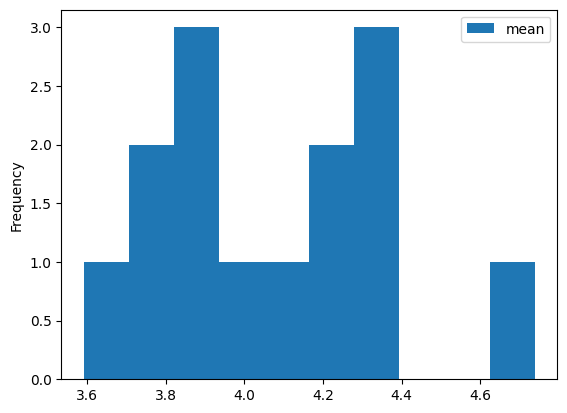

In [121]:
fig=plt.figure(figsize=(20,10))
df_language_mean.plot(x='language of the course',y='mean',kind='hist')


In [122]:
df_language_mean.loc[df_language_mean['mean']<=3]


,language of the course,Courses,mean
